# Business task

Accurately predict the medical insurance costs based on features given in the dataset.

# Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Loading dataset

In [2]:
df = pd.read_csv('Downloads\\insurance.csv')

# Dataset overview and statistical summary

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.shape

(1338, 7)

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


# Data cleaning

In [6]:
#checking for null values
df.isna().sum().sort_values(ascending = False)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There are no null values in the dataset.

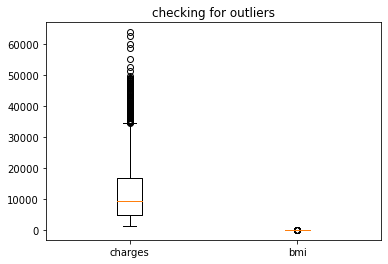

In [7]:
#checking for outliers
plt.boxplot(df[['charges', 'bmi']],labels=['charges', 'bmi'])
plt.title('checking for outliers');

### Dealing with outliers
As there are only 1338 observations, instead of removing outliers, I will be replacing the extreme high values with the upper limit values.

In [8]:
#creating helper function to change values
def optimise_higher_values(n):
    if n>=upper_limit:
        return upper_limit
    return n

In [9]:
# looping through the columns and changing the values
cols = ['charges', 'bmi']

for i in cols:
    perc_25 = df[i].quantile(.25)
    perc_75 = df[i].quantile(.75)

    iqr = perc_75 - perc_25

    upper_limit = perc_75 + 1.5 * iqr
    df[i]=df[i].apply(optimise_higher_values)

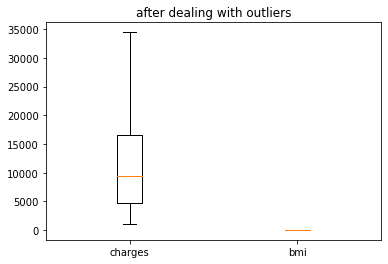

In [10]:
plt.boxplot(df[['charges', 'bmi']],labels=['charges', 'bmi'])
plt.title('after dealing with outliers');

# Exploratory data analysis

Text(0.5, 1.0, 'correlation of all features with target charges column')

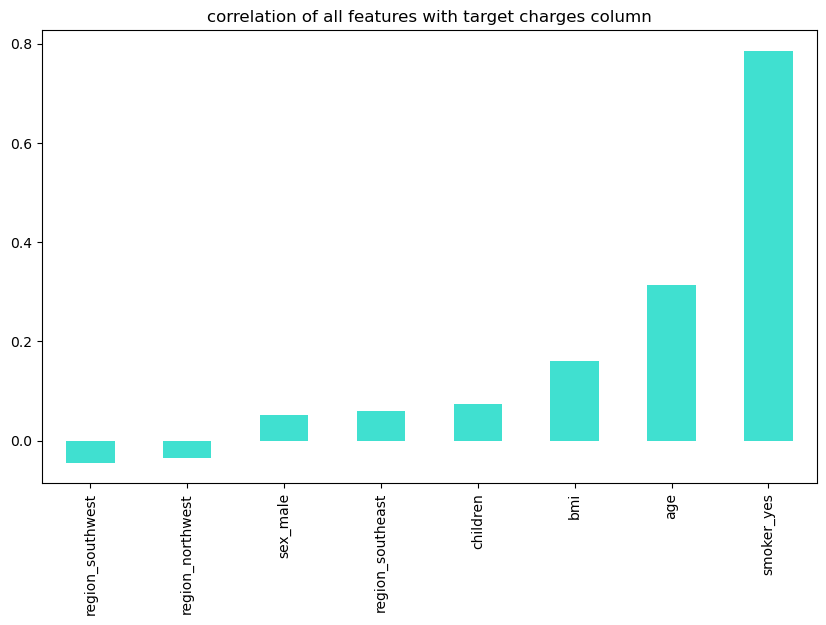

In [11]:
# checking correlation
plt.figure(figsize=(10,6),dpi=100)
pd.get_dummies(df,drop_first=True).corr()['charges'].sort_values()[:-1].plot(kind='bar',color='turquoise')
plt.title('correlation of all features with target charges column')

Smoker and age features are highly positively correlated with charges column

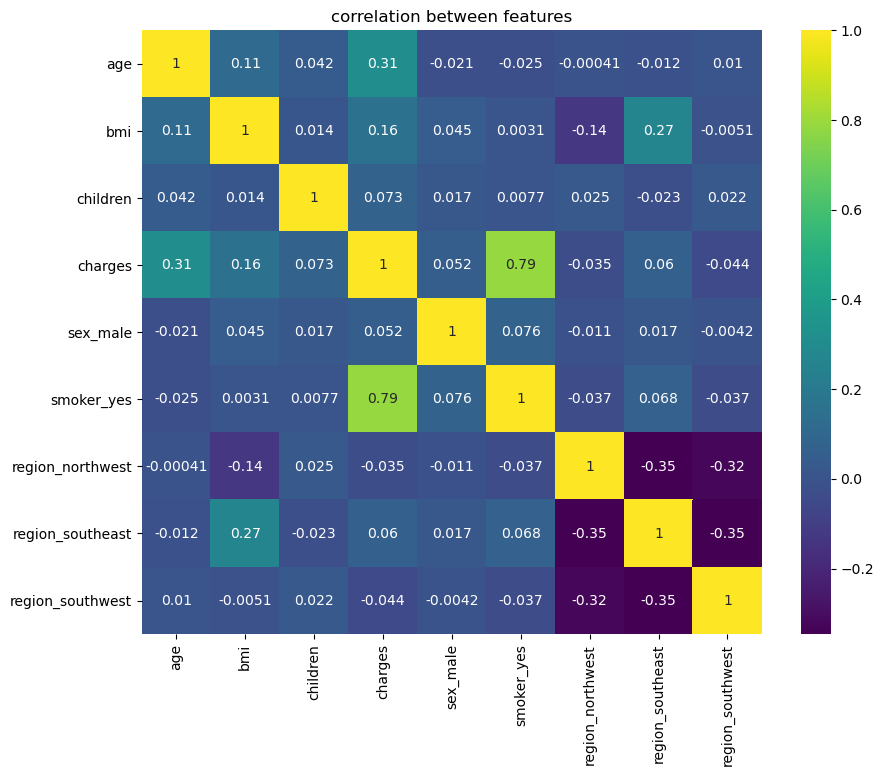

In [12]:
#plotting heatmap
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(pd.get_dummies(df,drop_first=True).corr(),annot=True,cmap='viridis')
plt.title('correlation between features');

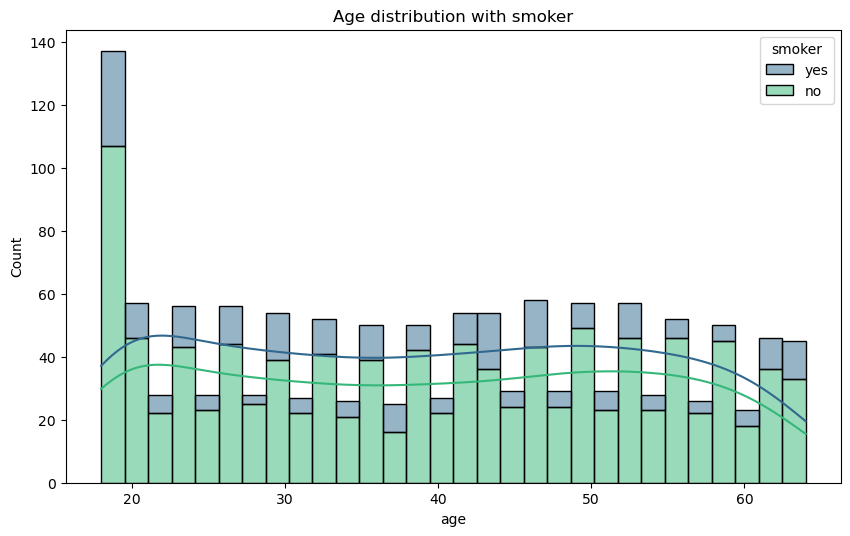

In [13]:
plt.figure(figsize=(10,6),dpi=100)
sns.histplot(data=df,x='age',hue='smoker',multiple='stack',bins=30,kde=True,palette='viridis')
plt.title('Age distribution with smoker');

There are lot of smokers below age of 20

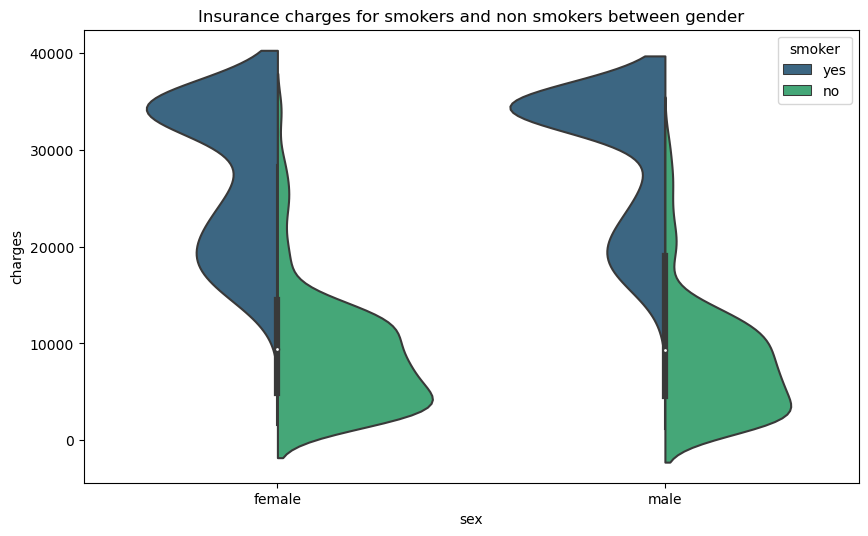

In [14]:
plt.figure(figsize=(10,6),dpi=100)
sns.violinplot(data=df,x='sex',y='charges',hue='smoker',split=True,palette='viridis')
plt.title('Insurance charges for smokers and non smokers between gender');

Insurance costs for majority of male and female smokers fall between 30000 and 40000. Whereas the majority of insurance costs for non smokers for both genders fall below 10000.

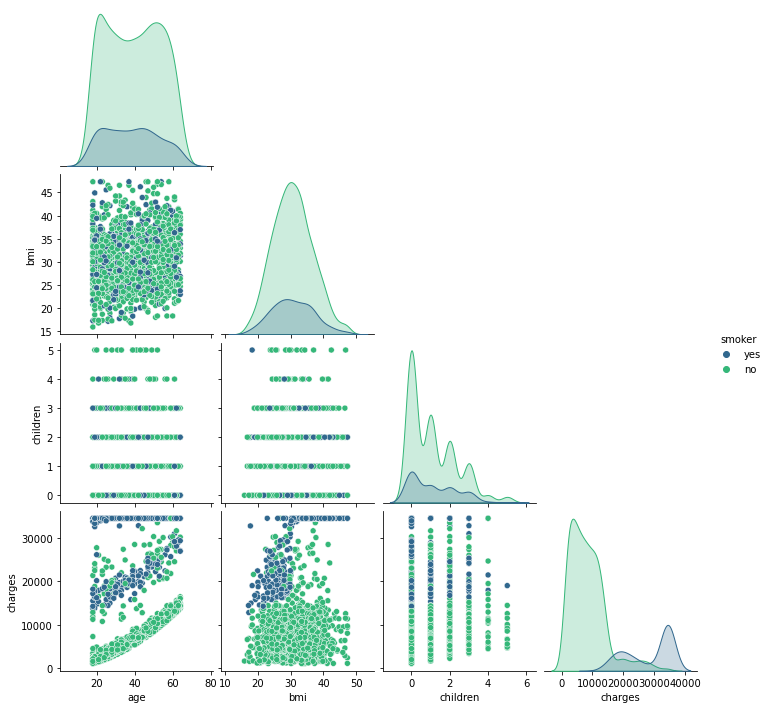

In [15]:
#checking distribution between features using pairplot
sns.pairplot(df,hue='smoker',corner=True,palette='viridis');

# Hypothesis testing

### One way ANOVA testing

* Null hypothesis (Ho): There is no difference in the insurance costs between smokers and non smokers.
* Alternative hypothesis (Ha): There is difference in the insurance costs between smokers and non smokers.

In [16]:
#creating formula
ols_formula = 'charges ~ C(smoker)'

In [17]:
#using OLS
OLS = ols(formula=ols_formula,data=df)

In [18]:
# fitting the OLS
model = OLS.fit()

In [19]:
# checking the summary results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     2159.
Date:                Thu, 04 May 2023   Prob (F-statistic):          2.93e-281
Time:                        17:02:08   Log-Likelihood:                -13599.
No. Observations:                1338   AIC:                         2.720e+04
Df Residuals:                    1336   BIC:                         2.721e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8429.3971    192.614     43.763      0.000    8051.539    8807.256
C(smoker)[T.yes]  1.978e+04    425.638     46.464      0.000    1.89e+04    2.06e+04
==============================================================================
Omnibus:                      170.645   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.870
Skew:                           0.852   Prob(JB):                     1.02e-61
Kurtosis:                       4.460   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# using one way ANOVA testing
sm.stats.anova_lm(model,type=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(smoker),1.0,8.522191e+10,8.522191e+10,2158.911216,2.929025e-281
Residual,1336.0,5.273791e+10,3.947449e+07,NaN,NaN


P value is very less. Null hypothesis can be rejected. Meaning,There is difference in the insurance costs between smokers and non smokers.

# Feature engineering

In [21]:
df = pd.get_dummies(df,drop_first=True)
df.head(2)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.9240,0,1,0,0,1
1,18,33.77,1,1725.5523,1,0,0,1,0


# Creating X, y and doing train - test split

In [22]:
X = df.drop('charges',axis=1)
y=df['charges']

In [23]:
# setting test size to 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
#instantiating standard scaler
scale = StandardScaler()

In [25]:
#scaling data
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

# Model building

# Linear Regression

In [26]:
# instantiating linear regression
l_model = LinearRegression()

In [27]:
l_model.fit(X_train_scaled,y_train)

LinearRegression()

In [28]:
y_pred = l_model.predict(X_test_scaled)

In [29]:
MAE_linear = mean_absolute_error(y_test,y_pred)

In [30]:
RMSE_linear = np.sqrt(mean_squared_error(y_test,y_pred))

In [31]:
model_score = round(l_model.score(X_test_scaled,y_test),3)

In [32]:
df_linear = pd.DataFrame(data = {'MAE':MAE_linear,'RMSE':RMSE_linear,'model_score':model_score},index=['Linear_Regression'])
df_linear

,MAE,RMSE,model_score
Linear_Regression,3396.262798,5060.59142,0.759


# Polynomial Regression

In [33]:
# looping through polynomial features 2,3,4 and checking MAE and RMSE
MAE=[]
RMSE=[]
r2_score_list=[]
for i in range(2,5):
    poly_model = PolynomialFeatures(degree=i)
    X_train_poly=poly_model.fit_transform(X_train_scaled)
    X_test_poly = poly_model.transform(X_test_scaled)
    l_model.fit(X_train_poly,y_train)
    y_pred = l_model.predict(X_test_poly)
    MAE.append(mean_absolute_error(y_test,y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    r2_score_list.append(l_model.score(X_test_poly,y_test))

In [34]:
MAE

[2715.8026259373128, 2700.8905328029846, 3238.008787131343]

In [35]:
RMSE

[4567.9236614144675, 4621.829885467065, 5329.487625814844]

In [36]:
r2_score_list

[0.8040076669473206, 0.7993545476795768, 0.7332082939499477]

From the above the polynomial regression models , for degree = 2 the model is performing better

In [37]:
df_poly = pd.DataFrame(data = {'MAE':MAE[0],'RMSE':RMSE[0],'model_score':round(r2_score_list[0],3)},index=['Polynomial_Regression(degree = 2)'])
df_poly

,MAE,RMSE,model_score
Polynomial_Regression(degree = 2),2715.802626,4567.923661,0.804


# Random Forest

In [38]:
rf_model = RandomForestRegressor()

In [39]:
rf_model.fit(X_train_scaled,y_train)

RandomForestRegressor()

In [40]:
y_pred = rf_model.predict(X_test_scaled)

In [41]:
MAE_rf = mean_absolute_error(y_test,y_pred)

In [42]:
RMSE_rf = np.sqrt(mean_squared_error(y_test,y_pred))

In [43]:
rf_score = round(rf_model.score(X_test_scaled,y_test),3)

In [44]:
df_rf= pd.DataFrame(data = {'MAE':MAE_rf,'RMSE':RMSE_rf,'model_score':round(rf_score,3)},index=['Random_forest_regressor'])
df_rf

,MAE,RMSE,model_score
Random_forest_regressor,2276.492966,4454.269773,0.814


# Random Forest with grid search CV

In [55]:
params = {'n_estimators':[70,80,90,92,95,100],'criterion' : ["mse", "mae"],'max_depth':[3,4,6,9,None],'max_features' : ["auto", "sqrt", "log2"]}

In [56]:
grid_model = GridSearchCV(estimator=rf_model,param_grid=params)

In [57]:
%%time
grid_model.fit(X_train_scaled,y_train)

Wall time: 3min 58s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [3, 4, 6, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [70, 80, 90, 92, 95, 100]})

In [58]:
grid_model.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 95}

In [59]:
rf_cv=grid_model.best_score_

In [60]:
y_pred = grid_model.predict(X_test_scaled)

In [61]:
MAE_rf_cv=mean_absolute_error(y_test,y_pred)

In [62]:
RMSE_rf_cv=np.sqrt(mean_squared_error(y_test,y_pred))

In [63]:
df_rf_cv= pd.DataFrame(data = {'MAE':MAE_rf_cv,'RMSE':RMSE_rf_cv,'model_score':round(rf_cv,3)},index=['Random_forest_regressor with Grid Search'])
df_rf_cv

,MAE,RMSE,model_score
Random_forest_regressor with Grid Search,2274.800493,4289.582582,0.814


There is slight improvement in MAE and RMSE using this model.

In [64]:
#checking feature importance
df_feat = pd.DataFrame(data={'name' : X.columns,'feat':grid_model.best_estimator_.feature_importances_}).sort_values('feat',ascending=False)
df_feat

,name,feat
4,smoker_yes,0.730823
0,age,0.147492
1,bmi,0.110118
2,children,0.010911
7,region_southwest,0.000361
3,sex_male,0.000170
5,region_northwest,0.000089
6,region_southeast,0.000037


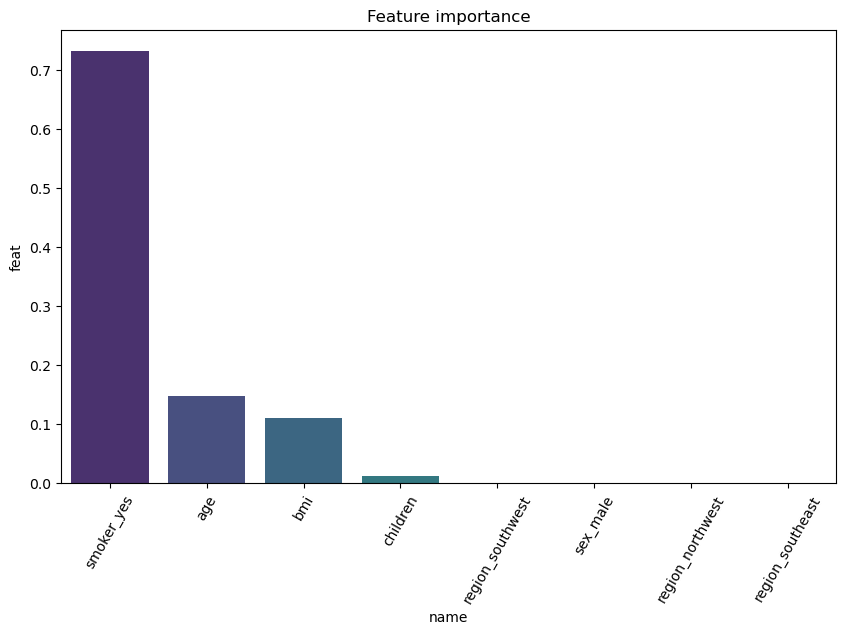

In [67]:
plt.figure(figsize=(10,6),dpi=100)
sns.barplot(data=df_feat,x='name',y='feat',palette='viridis')
plt.xticks(rotation = 60)
plt.title('Feature importance');

Smoker feature is very important feature in computing and deciding the insurance costs.

# Summary

In [69]:
df_1 = pd.concat([df_linear,df_poly])
df_1

,MAE,RMSE,model_score
Linear_Regression,3396.262798,5060.591420,0.759
Polynomial_Regression(degree = 2),2715.802626,4567.923661,0.804


In [70]:
df_2 = pd.concat([df_rf,df_rf_cv])
df_2

,MAE,RMSE,model_score
Random_forest_regressor,2276.492966,4454.269773,0.814
Random_forest_regressor with Grid Search,2274.800493,4289.582582,0.814


In [71]:
df_final = pd.concat([df_1,df_2])
df_final

,MAE,RMSE,model_score
Linear_Regression,3396.262798,5060.591420,0.759
Polynomial_Regression(degree = 2),2715.802626,4567.923661,0.804
Random_forest_regressor,2276.492966,4454.269773,0.814
Random_forest_regressor with Grid Search,2274.800493,4289.582582,0.814


In [73]:
df_final.sort_values(['MAE','RMSE'],ascending=[True,True])

,MAE,RMSE,model_score
Random_forest_regressor with Grid Search,2274.800493,4289.582582,0.814
Random_forest_regressor,2276.492966,4454.269773,0.814
Polynomial_Regression(degree = 2),2715.802626,4567.923661,0.804
Linear_Regression,3396.262798,5060.591420,0.759


Based on the above results, Random forest with grid search has performed better than other models.

# Final model

In [74]:
rf_model_final = RandomForestRegressor(criterion= 'mse',max_depth= 4,max_features= 'auto',n_estimators= 95)

In [75]:
#fitting final model to entire dataset
rf_model_final.fit(X,y)

RandomForestRegressor(max_depth=4, n_estimators=95)

# Testing the model

In [76]:
#dummy data
test1 = [[30,76,1,1,1,1,0,0]]

In [77]:
rf_model_final.predict(test1)

array([34482.76295061])

**Thankyou!**